# Исследование влияния наличия нескольких экспоненциальных составляющих в спектре на коэффициент нелинейности-неэкспоненциальности

## 1. Импорт необходимых библиотек и модулей

In [1]:
from joblib import Parallel, delayed

import matplotlib.cm as cm
import matplotlib.pyplot as plt

import numpy as np
from os import listdir
import pandas as pd
import tensorflow as tf

%matplotlib inline

from fsmodels import FrequencyScan

## 2. Модель частотного скана с для сигнала релаксации с одной экспоненциальной составляющей и коэффициентом нелинейности-неэкспоненциальности

### 2.1.  Описание модели в формулах
Выходной сигнал коррелятора спектрометра DLS-82E определяется выражением:
\begin{equation}
    \label{eq:eq1}
    S\left(\tau,C_A,F_0, t_1\right) = C_A K_{BS} K_{LS} \phi\left(\tau,F_0,t_1\right),
\end{equation}
где  
$C_A$ - амплитуда емкостного релаксационного сигнала,  
$K_{BS}$ - масштабный коэффициент, зависящий от чувствительности емкостного моста,  
$K_{LS}$ - масштабный коэффициент селектора,  
$\tau$ - постоянная времени релаксации гулбокого уровня,  
$F_0$ - частота сканирования импульсов заполнения,  
$t_1$ - длительность импульса заполнения,  
$\phi\left(\tau,F_0,t_1\right)$ - функция определяемая выражением:  
\begin{equation}
    \label{eq:eq2}
    \phi\left(\tau,F_0,t_1\right) = 
    M \tau F_0 e^{-\frac{0.05}{\tau F_0}}
    \left(1-e^{\frac{t_1 F_0-0.45}{\tau F_0}}
    -e^{-\frac{0.5}{\tau F_0}}+
    e^{\frac{t_1 F_0-0.95}{\tau F_0}}\right),
\end{equation}
где $M$ - масштабный множитель.

$$  M = \frac{1}{\max{\left[
    \tau F_0 e^{-\frac{0.05}{\tau F_0}}
    \left(1-e^{\frac{t_1 F_0-0.45}{\tau F_0}}
    -e^{-\frac{0.5}{\tau F_0}}+
    e^{\frac{t_1 F_0-0.95}{\tau F_0}}\right)
    \right]}}
$$

### 2.2. Кодирование модели
$$ \tau = 10^{time\_constant\_power} $$

$$ F_0 = 10^{frequency\_power}$$

$$ a = \tau F_0 $$

$$ b = t_1 F_0 $$

$$ exp0 = \exp{\left(\frac{-0.05}{a}\right)} $$

$$ exp1 = \exp{\left(\frac{b-0.45}{a}\right)} $$

$$ exp2 = \exp{\left(\frac{-0.5}{a}\right)} $$

$$ exp3 = \exp{\left(\frac{b-0.95}{a}\right)} $$

$$ \phi = M \cdot a \cdot exp0 \cdot \left(1.0 - exp1 - exp2 + exp3\right) $$

$$  M = \frac{1}{\max{\left[
    a \cdot exp0 \cdot \left(1.0 - exp1 - exp2 + exp3\right)
    \right]}}
$$

$$ S\left(\tau, A, F_0, t_1, p\right) = A\left[\phi\left(\tau,F_0,t_1\right)\right]^p $$

```Python
from fsmodels import FrequencyScan
```

## 3. Проверка модели. Пример 1.
- Постоянная времени: $\tau=0.005$ с.
- Амплитуда: $A=3.0$ .
- Длительность импульса заполнения: $t_1=20\cdot10^{-6}$ с.
- Коэффициент нелинейности-неэкспоненциальности: $p=1.0$

### 3.1. Чтение данных

In [2]:
data = pd.read_csv('test.csv', header = 0)
data['temperature_k'] = 298.0
data = data[['f_pulse', 'temperature_k', 'frequency_hz', 'dlts_pf']]

data.head()

,f_pulse,temperature_k,frequency_hz,dlts_pf
0,0.00002,298.0,1.000000,0.024528
1,0.00002,298.0,1.007863,-0.200976
2,0.00002,298.0,1.015787,0.004056
3,0.00002,298.0,1.023774,0.252659
4,0.00002,298.0,1.031823,0.307020


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   f_pulse        1000 non-null   float64
 1   temperature_k  1000 non-null   float64
 2   frequency_hz   1000 non-null   float64
 3   dlts_pf        1000 non-null   float64
dtypes: float64(4)
memory usage: 31.4 KB


### 3.2 График данных до масштабирования

In [4]:
def plot_experimental_data(data, freq_ix=0, dlts_ix=1, semilogx=False):
    array = np.array(data)
    xlim = np.array([1, 2500])
    if semilogx:
        plt.semilogx(array[:, freq_ix], array[:, dlts_ix], '.g', label='Экспериментальные\nданные', alpha = 0.3)
        plt.xlim(xlim)
        plt.xlabel('Частота, Гц')
    else:
        plt.plot(array[:, freq_ix], array[:, dlts_ix], '.g', label='Экспериментальные\nданные', alpha = 0.3)
        plt.xlim(np.log10(xlim))
        plt.xlabel('log10(Частота, Гц)')
        
    plt.grid()
    plt.legend()
    plt.ylabel('DLTS')
    plt.show()

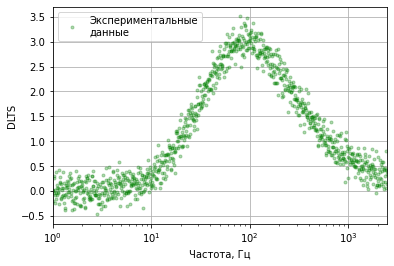

In [5]:
plot_experimental_data(data, freq_ix=2, dlts_ix=3, semilogx=True)

### 3.3. Нормализация (масштабирование) данных
Переход к десятичному логарифму частоты

In [6]:
data.frequency_hz = np.log10(data.frequency_hz)
data.head()

,f_pulse,temperature_k,frequency_hz,dlts_pf
0,0.00002,298.0,0.000000,0.024528
1,0.00002,298.0,0.003401,-0.200976
2,0.00002,298.0,0.006803,0.004056
3,0.00002,298.0,0.010204,0.252659
4,0.00002,298.0,0.013605,0.307020


### 3.4. График данных после нормализации 

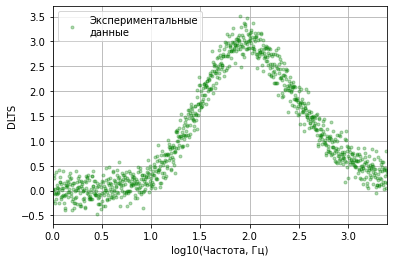

In [7]:
plot_experimental_data(data, freq_ix=2, dlts_ix=3, semilogx=False)

### 3.5. Преобразование к массива 

In [8]:
data = data.to_numpy()

### 3.6. Идентификация параметров модели без изменения $p$

In [9]:
fs = FrequencyScan(fit_p_coef = False,
                   learning_rate = 0.2,
                   n_iters = 1000,
                   stop_val = 10**-10,
                   verbose = True,
                   
                   tf_in_out = False
                  )

initial_dlts = fs(data[:,2])

fit_results = fs.fit(data[:,2], data[:,3])

iter # 0
amp: 3.5
tau: -2.0
p: 1.0
Loss: 0.5467947739608969
iter # 1
amp: 3.420822497077624
tau: -2.5581896142922083
p: 1.0
Loss: 0.39972027843267505
iter # 2
amp: 3.3593813999403945
tau: -2.0885737495966823
p: 1.0
Loss: 0.2889885710701853
iter # 3
amp: 3.3075527966474074
tau: -2.4857117974105605
p: 1.0
Loss: 0.2237178073010877
iter # 4
amp: 3.2660412189934784
tau: -2.1456350143740153
p: 1.0
Loss: 0.170692788838489
iter # 5
amp: 3.2300833377135056
tau: -2.434374495928271
p: 1.0
Loss: 0.13492335387400947
iter # 6
amp: 3.200915675279533
tau: -2.1892217499352906
p: 1.0
Loss: 0.10678388341931784
iter # 7
amp: 3.1752606766529694
tau: -2.3952132927586196
p: 1.0
Loss: 0.08716476726658395
iter # 8
amp: 3.1541565733695944
tau: -2.222766154887432
p: 1.0
Loss: 0.07235424602703404
iter # 9
amp: 3.1353579861600607
tau: -2.3656100010628247
p: 1.0
Loss: 0.06202734150736956
iter # 10
amp: 3.1196426371892234
tau: -2.24787566529073
p: 1.0
Loss: 0.05452704909945386
iter # 11
amp: 3.1055067696859355
tau: 

In [10]:
fit_results

,amplitude,time_constant_power,p_coef,loss
0,3.5,-2.0,1.0,0.546795
1,3.420822,-2.55819,1.0,0.39972
2,3.359381,-2.088574,1.0,0.288989
3,3.307553,-2.485712,1.0,0.223718
4,3.266041,-2.145635,1.0,0.170693
...,...,...,...,...
79,2.994527,-2.300517,1.0,0.037697
80,2.994521,-2.300517,1.0,0.037697
81,2.994515,-2.300517,1.0,0.037697
82,2.99451,-2.300517,1.0,0.037697


### 3.7. График с результатами идентификации модели

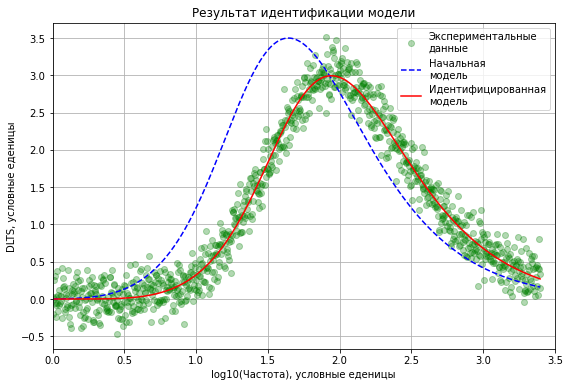

In [11]:
def plot_model(data, initial_dlts, model, freq_ix=0, dlts_ix=1):
    fig, ax = plt.subplots(1, 1, figsize=(9, 6))

    ax.plot(data[:,freq_ix], data[:,dlts_ix], 'og', label='Экспериментальные\nданные', alpha=0.3)
    ax.plot(data[:,freq_ix], initial_dlts, '--b', label='Начальная\nмодель', alpha=1)
    ax.plot(data[:,freq_ix], model(data[:,freq_ix]), '-r', label='Идентифицированная\nмодель', alpha=1)
    ax.grid()
    ax.set_xlim([0, 3.5])
    ax.legend()
    ax.set_ylabel('DLTS, условные еденицы')
    ax.set_xlabel('log10(Частота), условные еденицы')
    plt.title('Результат идентификации модели')
    plt.show()
    
plot_model(data, initial_dlts, fs, freq_ix=2, dlts_ix=3)

### 3.8. График изменения параметров во время оптимизации

In [12]:
x = np.linspace(2, 4, 40)
y = np.linspace(-3, -1, 40)

X, Y = np.meshgrid(x, y)

x = X.flatten()
y = Y.flatten()

n_jobs = -1

def get_mse(x, y, freq, dlts):

    amp = tf.Variable(x, dtype='float64')
    time_const = tf.Variable(y, dtype='float64')

    fs = FrequencyScan(amplitude = amp,
                       time_constant_power = time_const,
                       filling_pulse = 20*10**-6,
                       p_coef = 1.0)
    mse = tf.reduce_mean(tf.square(dlts - fs(freq))).numpy()

    return mse

Z = Parallel(n_jobs=n_jobs)(delayed(get_mse)(a, b, data[:,2], data[:,3]) for a, b in zip(x, y))
Z = np.reshape(np.c_[Z], X.shape)

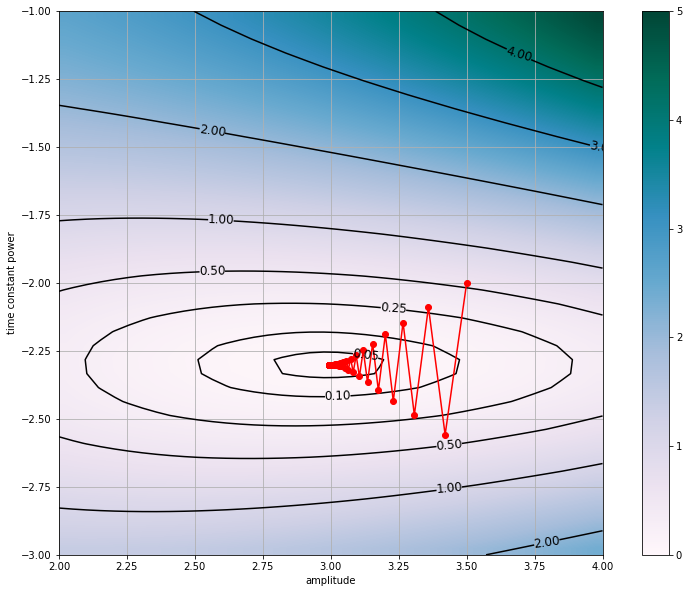

In [13]:
fig, ax = plt.subplots(figsize=(14,10))
CS = ax.contour(X, Y, Z, 
                levels=[0, 0.05, 0.1, 0.25, 0.5, 1, 2.0, 3.0, 4.0, 5.0], 
                colors='k')
ax.clabel(CS, 
          inline=True, 
          fontsize=12)

IM = ax.imshow(Z, 
               interpolation='bilinear', 
               origin='lower',
               cmap=cm.PuBuGn, 
               extent=(2, 4, -3, -1), 
               vmin=0, 
               vmax=np.round(Z.max()))

ax.plot(fit_results.amplitude.to_numpy(), fit_results.time_constant_power.to_numpy(), 'o-r')
# ax.set_title('Simplest default with labels')
fig.colorbar(IM, shrink=1)

ax.set_xlabel('amplitude')
ax.set_ylabel('time constant power')
plt.grid()
plt.show()